In [1]:
import os
import numpy as np
import cv2, pydicom
import matplotlib.pyplot as plt

In [4]:
class Dicom():
    def __init__(self, dicom_path=None, window_center=None, window_width=None, auto=None):
        self.dicom_path = dicom_path
        self.window_center = window_center
        self.window_width = window_width
        self.auto = auto
        
        self.hu_img = self.dicom_to_array(self.dicom_path)

        self.hist, self.bins = np.histogram(self.hu_img.flatten(), \
            int(np.max(self.hu_img) - np.min(self.hu_img) + 1), [np.min(self.hu_img), np.max(self.hu_img) + 1])
        self.cdf = self.hist.cumsum()
        if auto == "all":
            clip_min = np.min(self.hu_img) + np.where(self.cdf < self.cdf[-1] * 0.02)[0][-1]
            clip_max = np.min(self.hu_img) + np.where(self.cdf > self.cdf[-1] * 0.99)[0][0]

            self.window_center = (clip_max + clip_min) / 2
            self.window_width = (clip_max - clip_min)

        if self.window_center is not None and self.window_width is not None:
            self.img = self.dicom_windowing(self.hu_img, self.window_center, self.window_width)
        else:
            self.img = self.hu_img

    def dicom_to_array(self, dicom_path):
        self.slice = pydicom.read_file(dicom_path)
        s = int(self.slice.RescaleSlope)
        b = int(self.slice.RescaleIntercept)
        return s * self.slice.pixel_array + b

    def get_min_max_window(self, hu_img):
        img_min = np.min(hu_img)
        img_max = np.max(hu_img)
        window_center = (img_max + img_min) / 2
        window_width = img_max - img_min
        return window_center, window_width

    def dicom_windowing(self, image, window_center, window_width):
        img_min = window_center - window_width / 2
        img_max = window_center + window_width / 2
        window_img = np.clip(image, img_min, img_max)
        return window_img
    
    def get_image(self):
        return self.img
    
    def get_hu_image(self):
        return self.hu_img
    
    def change_window(self, window_center, window_width):
        self.window_center = window_center
        self.window_width = window_width
        self.img = self.dicom_windowing(self.hu_img, self.window_center, self.window_width)
    
    def window_option(self, option):
        # (window center, width)
        options = {'brain' : (40, 80), 'soft tissues' : (40, 400), 'bone' : (400, 1800)}
        if option in options:
            self.window_center, self.window_width = options[option]
            self.change_window(self.window_center, self.window_width)
        else:
            print(f"input option : {option}, plz input right option")


In [5]:
data_list = os.listdir('data/Sample1')
dicom_path = os.path.join('data/Sample1',data_list[0])
dicom_file = Dicom(dicom_path=dicom_path, auto="all")
image = dicom_file.get_image()
hu_img = dicom_file.get_hu_image()

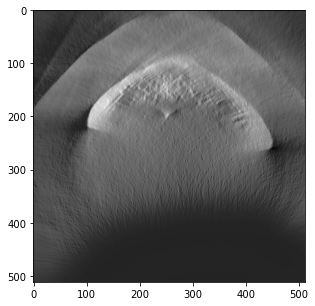

In [6]:
plt.figure(figsize=(10,5))
plt.imshow(hu_img, cmap='gray')

Text(0.5, 1.0, 'Window Center : 204.5, Window Width : 751')

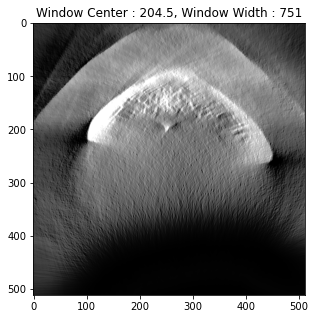

In [7]:
plt.figure(figsize=(10,5))
plt.imshow(image, cmap="gray")
plt.title(f"Window Center : {dicom_file.window_center}, Window Width : {dicom_file.window_width}")

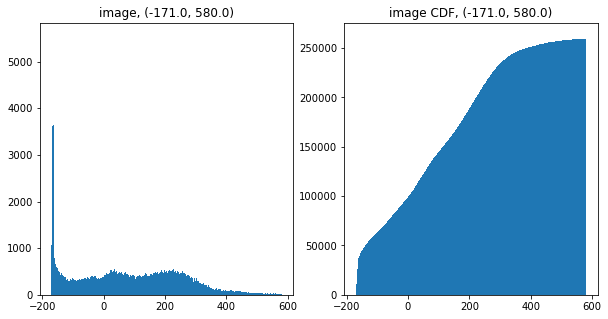

In [8]:
hist1, bins1 = np.histogram(image.flatten(), int(np.max(image) - np.min(image) + 1), [np.min(image), np.max(image) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(image.flatten(), bins1)
plt.title(f"image, {np.min(image), np.max(image)}")
plt.subplot(1, 2, 2)
plt.hist(image.flatten(), bins1, cumulative=True)
plt.title(f"image CDF, {np.min(image), np.max(image)}")
plt.show()

Text(0.5, 1.0, 'Window Center : 40, Window Width : 400')

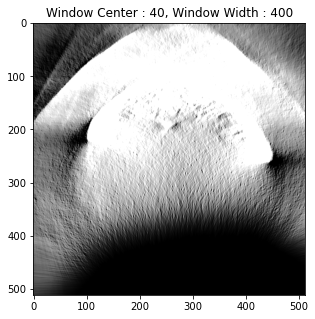

In [9]:
dicom_file.window_option('soft tissues')
plt.figure(figsize=(10,5))
plt.imshow(dicom_file.img, cmap="gray")
plt.title(f"Window Center : {dicom_file.window_center}, Window Width : {dicom_file.window_width}")

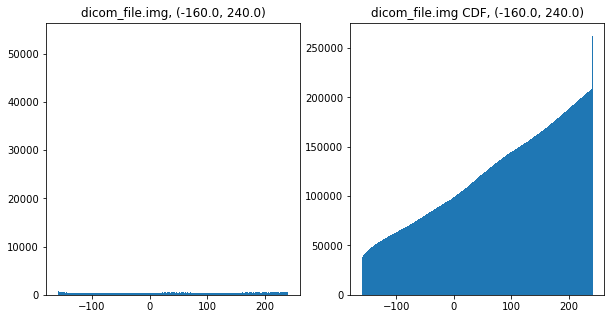

In [10]:
hist2, bins2 = np.histogram(dicom_file.img.flatten(), int(np.max(dicom_file.img) - np.min(dicom_file.img) + 1), [np.min(dicom_file.img), np.max(dicom_file.img) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(dicom_file.img.flatten(), bins2)
plt.title(f"dicom_file.img, {np.min(dicom_file.img), np.max(dicom_file.img)}")
plt.subplot(1, 2, 2)
plt.hist(dicom_file.img.flatten(), bins2, cumulative=True)
plt.title(f"dicom_file.img CDF, {np.min(dicom_file.img), np.max(dicom_file.img)}")
plt.show()

In [11]:
img_he = cv2.equalizeHist(dicom_file.hu_img)

error: OpenCV(4.5.5) D:\bld\libopencv_1647515827160\work\modules\imgproc\src\histogram.cpp:3439: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'cv::equalizeHist'


In [12]:
test_img = cv2.imread('data/dog.jpg', 0)
test_img.shape

(560, 560)

In [13]:
test_he = cv2.equalizeHist(test_img)

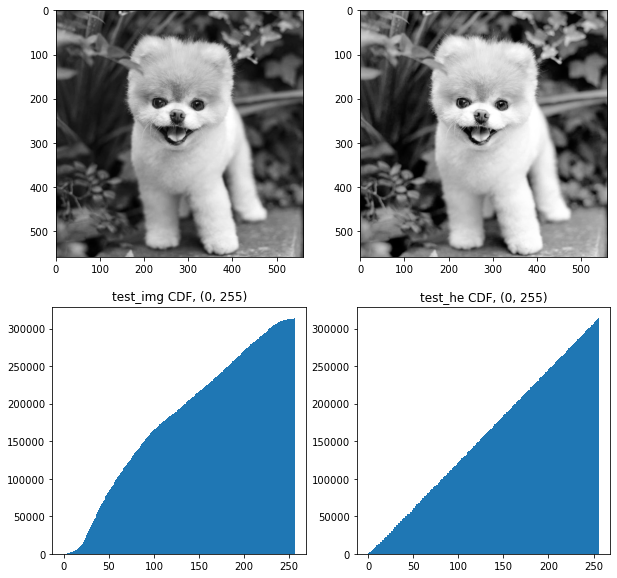

In [14]:
plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1)
plt.imshow(test_img, cmap='gray')

plt.subplot(2, 2, 2)
plt.imshow(test_he, cmap='gray')

hist3, bins3 = np.histogram(test_img.flatten(), int(np.max(test_img) - np.min(test_img) + 1), [np.min(test_img), np.max(test_img) + 1])
hist4, bins4 = np.histogram(test_he.flatten(), int(np.max(test_he) - np.min(test_he) + 1), [np.min(test_he), np.max(test_he) + 1])

plt.subplot(2, 2, 3)
plt.hist(test_img.flatten(), bins3, cumulative=True)
plt.title(f"test_img CDF, {np.min(test_img), np.max(test_img)}")
plt.subplot(2, 2, 4)
plt.hist(test_he.flatten(), bins4, cumulative=True)
plt.title(f"test_he CDF, {np.min(test_he), np.max(test_he)}")
plt.show()

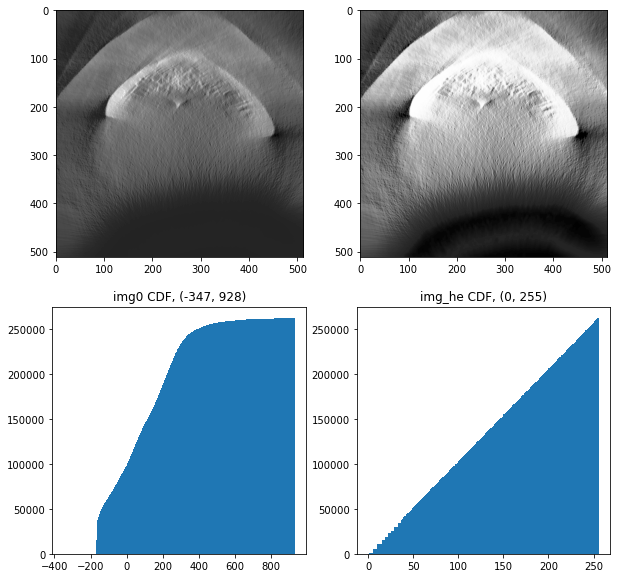

In [15]:
img0 = dicom_file.hu_img

hist0, bins0 = np.histogram(img0.flatten(), int(np.max(img0) - np.min(img0) + 1), [np.min(img0), np.max(img0) + 1])
cdf0 = hist0.cumsum()

cdf_m = np.ma.masked_equal(cdf0, 0)
cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())

cdf = np.ma.filled(cdf_m, 255).astype('uint8')

img1 = img0 - img0.min()
img_he = cdf[img1]

plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1)
plt.imshow(img0, cmap='gray')

plt.subplot(2, 2, 2)
plt.imshow(img_he, cmap='gray')

hist3, bins3 = np.histogram(img0.flatten(), int(np.max(img0) - np.min(img0) + 1), [np.min(img0), np.max(img0) + 1])
hist4, bins4 = np.histogram(img_he.flatten(), int(np.max(img_he) - np.min(img_he) + 1), [np.min(img_he), np.max(img_he) + 1])

plt.subplot(2, 2, 3)
plt.hist(img0.flatten(), bins3, cumulative=True)
plt.title(f"img0 CDF, {np.min(img0), np.max(img0)}")
plt.subplot(2, 2, 4)
plt.hist(img_he.flatten(), bins4, cumulative=True)
plt.title(f"img_he CDF, {np.min(img_he), np.max(img_he)}")
plt.show()